In [37]:
# Import các thư viện
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
from imutils import paths
from collections import Counter
import pickle


In [38]:
# Tiền xử lý ảnh thành mảng
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        self.dataFormat = dataFormat

    def preprocess(self, image):
        return img_to_array(image, data_format=self.dataFormat)


In [39]:
# Resize ảnh về kích thước cố định
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [40]:
# Load dataset từ thư mục
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors if preprocessors is not None else []

    def load(self, imagePaths, verbose=-1):
        data, labels = [], []

        for (i, imagePath) in enumerate(imagePaths):
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            for p in self.preprocessors:
                image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print(f"[INFO] Đã xử lý {i + 1}/{len(imagePaths)} ảnh")

        return (np.array(data), np.array(labels))

In [41]:
# Thuật toán KNN from scratch
class KNNClassifierScratch:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, x):
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test)

In [42]:
# Nạp dữ liệu ảnh
print("[INFO] Nạp ảnh để train...")
imagePaths = list(paths.list_images("datasets/animals"))

[INFO] Nạp ảnh để train...


In [43]:
# Tiền xử lý
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.reshape((data.shape[0], 32 * 32 * 3))

[INFO] Đã xử lý 500/3000 ảnh
[INFO] Đã xử lý 1000/3000 ảnh
[INFO] Đã xử lý 1500/3000 ảnh
[INFO] Đã xử lý 2000/3000 ảnh
[INFO] Đã xử lý 2500/3000 ảnh
[INFO] Đã xử lý 3000/3000 ảnh


In [44]:
print("[INFO] Dung lượng Ma trận đặc trưng: {:.1f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] Dung lượng Ma trận đặc trưng: 9.0MB


In [45]:
# Mã hóa nhãn
le = LabelEncoder()
labels = le.fit_transform(labels)


In [46]:
# Chia dữ liệu
(trainData, testData, trainLabel, testLabel) = train_test_split(data, labels, test_size=0.25, random_state=42)

[INFO] Đang đánh giá k-NN từ k=1 đến k=100...
[INFO] k=1, accuracy=0.3880
[INFO] k=2, accuracy=0.3880
[INFO] k=3, accuracy=0.3853
[INFO] k=4, accuracy=0.4040
[INFO] k=5, accuracy=0.3973
[INFO] k=6, accuracy=0.4013
[INFO] k=7, accuracy=0.3827
[INFO] k=8, accuracy=0.3787
[INFO] k=9, accuracy=0.3787
[INFO] k=10, accuracy=0.3787
[INFO] Giá trị k tối ưu: 4, với độ chính xác cao nhất: 0.4040


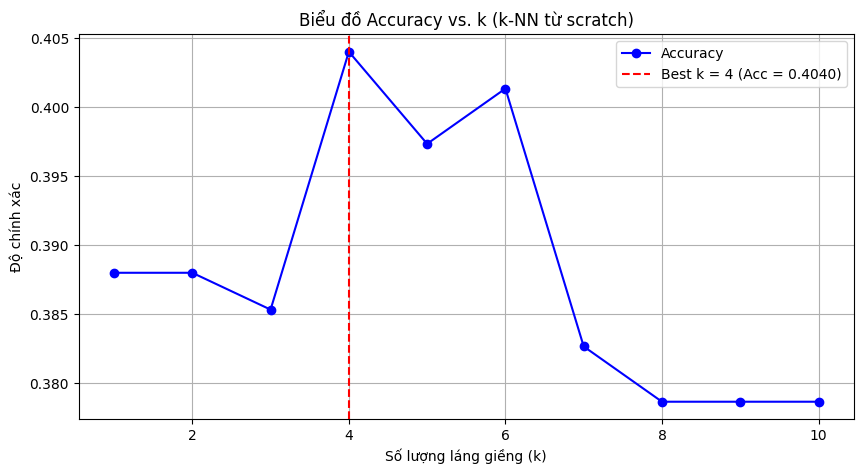

In [ ]:
# Đánh giá k từ 1 đến 100
print("[INFO] Đang đánh giá k-NN từ k=1 đến k=100...")
accuracies = []

for k in range(1, 11):
    model = KNNClassifierScratch(k=k)
    model.fit(trainData, trainLabel)
    acc = model.score(testData, testLabel)
    accuracies.append(acc)
    print(f"[INFO] k={k}, accuracy={acc:.4f}")

# Tìm k tốt nhất
best_k = np.argmax(accuracies) + 1
best_acc = accuracies[best_k - 1]
print(f"[INFO] Giá trị k tối ưu: {best_k}, với độ chính xác cao nhất: {best_acc:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), accuracies, marker="o", linestyle="-", color="b", label="Accuracy")
plt.axvline(x=best_k, color="r", linestyle="--", label=f"Best k = {best_k} (Acc = {best_acc:.4f})")
plt.xlabel("Số lượng láng giềng (k)")
plt.ylabel("Độ chính xác")
plt.title("Biểu đồ Accuracy vs. k (k-NN từ scratch)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = KNNClassifierScratch(k=best_k)
model.fit(trainData, trainLabel)

# Lưu mô hình
with open("knn_model_scratch.pkl", "wb") as f:
    pickle.dump(model, f)


<Figure size 600x600 with 0 Axes>

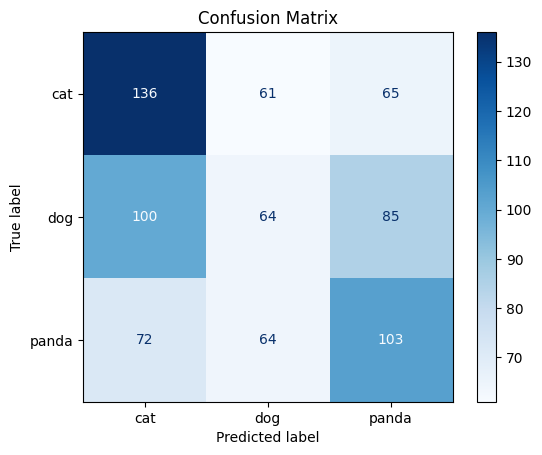

In [49]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(testData)

# Ma trận confusion
cm = confusion_matrix(testLabel, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Hiển thị ma trận confusion
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [50]:
print(classification_report(testLabel, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         cat       0.44      0.52      0.48       262
         dog       0.34      0.26      0.29       249
       panda       0.41      0.43      0.42       239

    accuracy                           0.40       750
   macro avg       0.40      0.40      0.40       750
weighted avg       0.40      0.40      0.40       750



[INFO] Đang nạp ảnh mẫu để phân lớp...
[INFO] Nạp model mạng pre-trained ...
[INFO] Đang dự đoán để phân lớp...


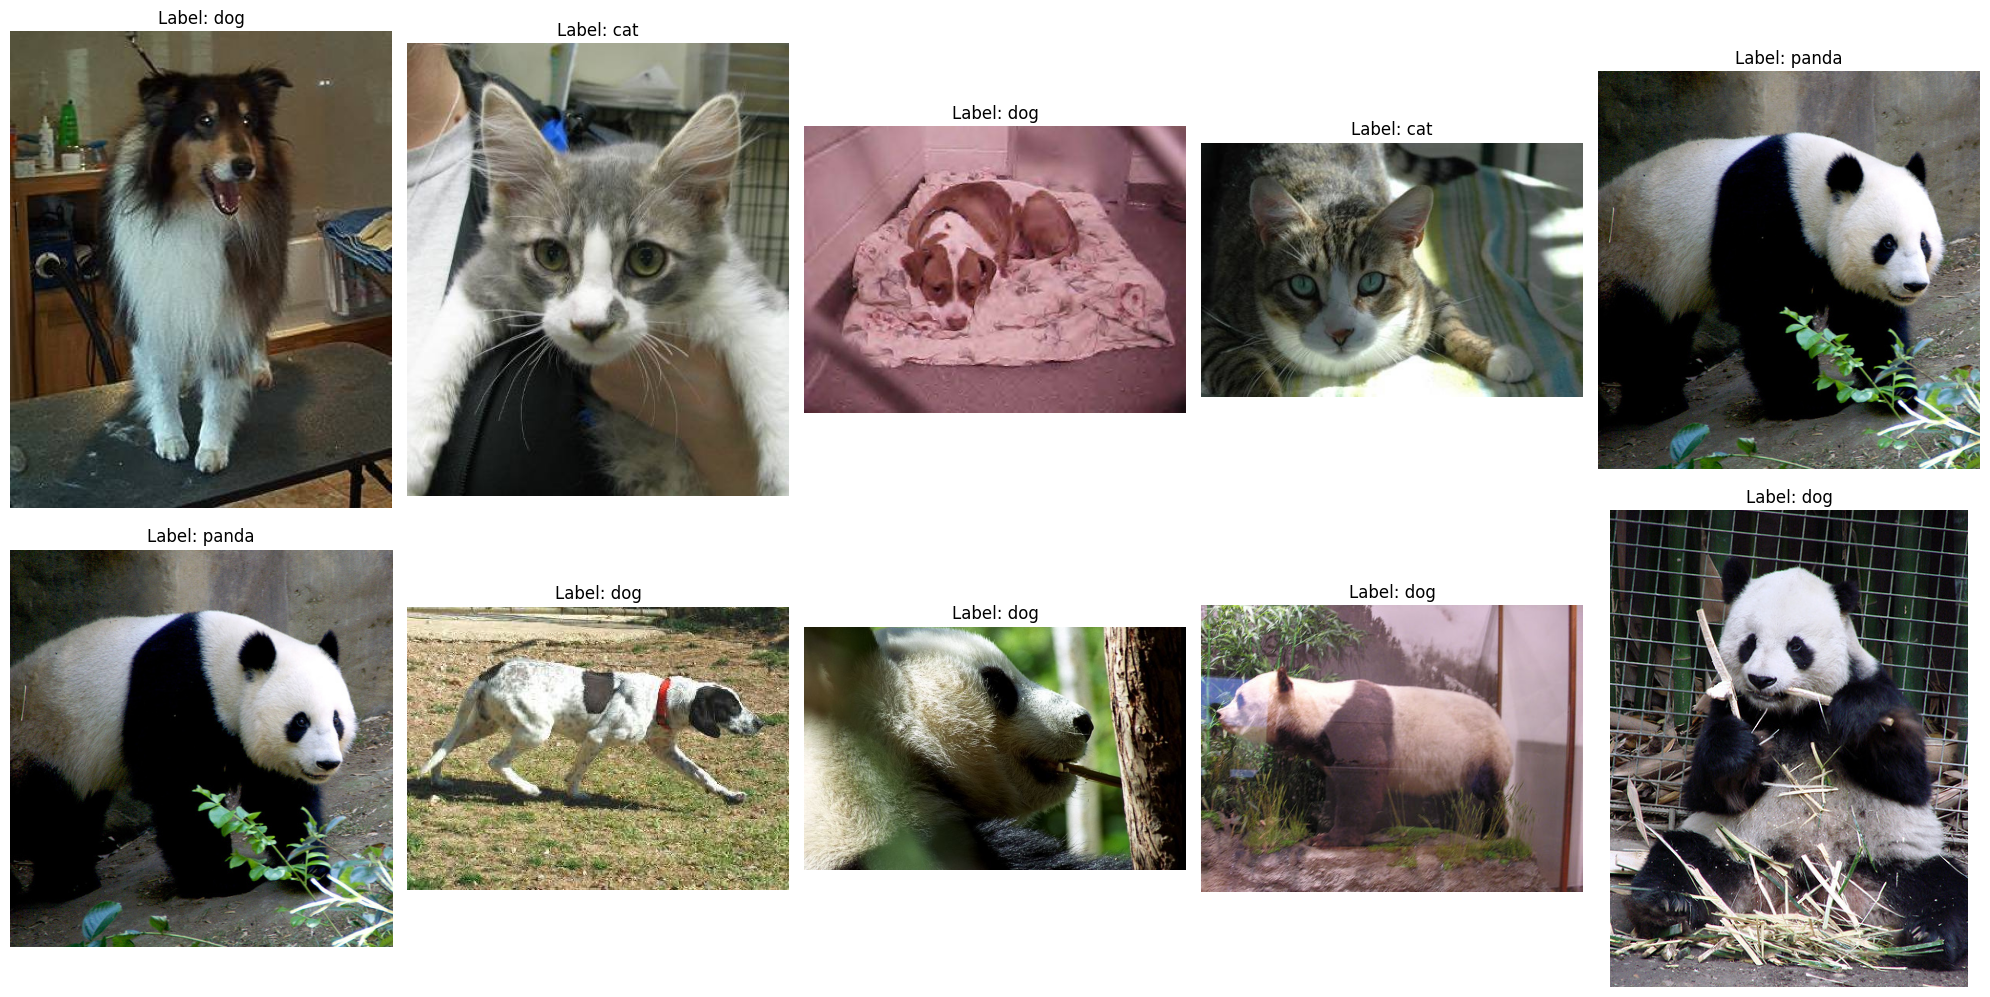

In [52]:
# Khởi tạo danh sách nhãn tương ứng
classLabels = ["cat", "dog", "panda"]

# Lấy danh sách các hình ảnh trong folder "image"
print("[INFO] Đang nạp ảnh mẫu để phân lớp...")
imagePaths = np.array(list(paths.list_images("image")))
idxs = np.random.randint(0, len(imagePaths), size=(10,))
imagePaths = imagePaths[idxs]

# Tiền xử lý dữ liệu ảnh
sp = SimplePreprocessor(32, 32)     # Resize ảnh
iap = ImageToArrayPreprocessor()    # Convert ảnh thành array (nếu có định nghĩa lớp này)
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths)
data = data.reshape((data.shape[0], 3072))

# Nạp mô hình đã lưu
print("[INFO] Nạp model mạng pre-trained ...")
model = pickle.load(open("knn_model_scratch.pkl", "rb"))

# Dự đoán nhãn ảnh
print("[INFO] Đang dự đoán để phân lớp...")
preds = model.predict(data)

# Hiển thị kết quả
plt.figure(figsize=(20, 10))
for i, imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = classLabels[preds[i]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()